# Analyze CV Results
Compile the results of the CV tests

In [1]:
%matplotlib inline
import scipy as sp
import numpy as np
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
import json
import gzip
import os

Key variables to change

In [2]:
# Data to analyze / how to analyze
tests = ['no-processing', 'process-variable', 'split-model', 'meltspin-stacked']
test_names = ['No\nProcessing', 'Processing\nAttribute', 'Separate\nModels', 'Stacked\nModels']

n_cv = 250 # Number of iterations for CV test

# Output settings
plotWidth = 89 / 22.5
plotHeight = plotWidth * 3.0 / 4

## Create Analysis Functions
This is the part of the script for creating and testing the analysis functions. These will be employed on all tests and used to generate figures later

In [3]:
def read_cv_data(d):
    """Read the CV results for a certain test

    :param d: Name of test directory"""

    json_data = json.load(gzip.open(os.path.join(d, 'cv_test_data.json.gz'), 'rb'))

    # Get processing type names
    proc_names = json_data['properties'][1]['classes']

    # Get a few different stats
    composition = [e['composition'] for e in json_data['entries']]
    processing = [proc_names[e['properties'][1]['measured']] for e in json_data['entries']]
    gfa_meas = [e['properties'][0]['measured'] for e in json_data['entries']]
    gfa_pred = [e['properties'][0]['predicted'] for e in json_data['entries']]
    gfa_am_prob = [e['properties'][0]['probabilities'][0] for e in json_data['entries']]

    # Return as a data frame
    return pd.DataFrame(list(zip(composition,processing,gfa_meas,gfa_pred,gfa_am_prob)),
        columns=['composition','processing','gfa_measured','gfa_predicted','gfa_prob_am'])

In [4]:
data = read_cv_data('meltspin-stacked')

In [5]:
def assign_test_id(data):
    """Mark which CV iteration each point came from.
    
    :param data: DataFrame, data to be labelled"""
    test_size = len(data) / n_cv
    data['testID'] = [int(i / test_size) for i in range(len(data))]

In [6]:
assign_test_id(data)

In [7]:
def compute_accuracy(data):
    """Compute the classification accuracy
    
    :param data: DataFrame, data used to compute accuracy"""
    return float(sum(data['gfa_measured'] == data['gfa_predicted'])) / float(len(data))

In [8]:
print("Accuracy: %.2f%%"%(compute_accuracy(data)*100))

Accuracy: 89.71%


In [9]:
def compute_roc_auc(data):
    """Compute the area under ROC curve"""
    return metrics.roc_auc_score(data['gfa_measured'], 1.0-data['gfa_prob_am'])
def compute_roc(data):
    return metrics.roc_curve(data['gfa_measured'], 1.0 - data['gfa_prob_am'])

In [10]:
print("Area Under ROC: %f"%compute_roc_auc(data))

Area Under ROC: 0.956577


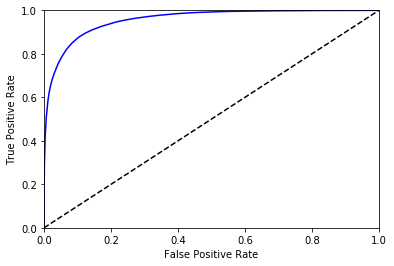

In [11]:
fig, ax = plt.subplots()

def plot_roc_curve(ax, data):
    fpr, tpr, thr = compute_roc(data)

    ax.plot(fpr,tpr,'b')
    ax.plot([0,1],[0,1],'k--')

    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

plot_roc_curve(ax, data)

## Analyze All the Tests
Get the accuracy for all tests, broken down by 'sputtering' and 'meltspin' processing variables. Also get the 90% confidence intervals

In [12]:
def get_results(data):
    """Compute all of the test statistics for a single dataset. 
    
    :param data: Results to be analyzed
    :return: dict, all results"""
    
    output = dict()
    
    # Assign ids to each test
    assign_test_id(data)
    
    # Get the stats over all tests
    acc = [compute_accuracy(group) for gid,group in data.groupby('testID')]
    output['accuracy_total'], _, _ = sp.stats.bayes_mvs(acc)
    
    roc = [compute_roc_auc(group) for gid,group in data.groupby('testID')]
    output['rocauc_total'], _, _ = sp.stats.bayes_mvs(roc)
    
    output['roc_total'] = compute_roc(data)
    
    # Break down by processing condition
    for proc in ['meltspin', 'sputtering']:
        sub = data.query('processing == "%s"'%proc)
        
        acc = [compute_accuracy(group) for gid,group in sub.groupby('testID')]
        output['accuracy_%s'%proc], _, _ = sp.stats.bayes_mvs(acc)

        roc = [compute_roc_auc(group) for gid,group in sub.groupby('testID')]
        output['rocauc_%s'%proc], _, _ = sp.stats.bayes_mvs(roc)

        output['roc_%s'%proc] = compute_roc(sub)
    
    return output

In [13]:
results = get_results(data)
print(results.keys())

dict_keys(['accuracy_total', 'rocauc_total', 'roc_total', 'accuracy_meltspin', 'rocauc_meltspin', 'roc_meltspin', 'accuracy_sputtering', 'rocauc_sputtering', 'roc_sputtering'])


In [14]:
%%time
results = dict([(test,get_results(read_cv_data(test))) for test in tests])

CPU times: user 41.5 s, sys: 620 ms, total: 42.1 s
Wall time: 42.1 s


In [15]:
results.keys()

dict_keys(['no-processing', 'process-variable', 'split-model', 'meltspin-stacked'])

## Compare the results
Compare a few different tests. Plots show the overall accuracy (or ROC AUC) for each model, the accuracy broken down by meltspin and sputtering. Plots are complete with the 90% CI as error bars

,method,total,total_err,meltspin,meltspin_err,sputtering,sputtering_err
0,no-processing,89.301253,0.083391,89.249935,0.090615,89.747019,0.246435
1,process-variable,89.480368,0.082573,89.329183,0.092630,90.663975,0.248704
2,split-model,89.696909,0.087284,89.459694,0.092985,91.560797,0.229157
3,meltspin-stacked,89.706934,0.083830,89.496270,0.088651,91.353476,0.250748


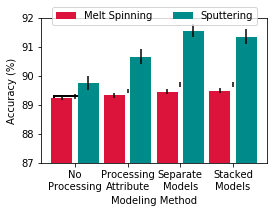

In [16]:
fig, ax = plt.subplots()


# Plot the data for all 
data = pd.DataFrame(tests, columns=['method'])
acc = [results[t]['accuracy_total'][0]*100 for t in tests]
acc_err = [sum(np.abs(np.array(results[t]['accuracy_total'][1])*100 - mean))/2 for t,mean in zip(tests,acc)]
rects = ax.bar(np.arange(0,len(acc)), acc, width=0.8,
               facecolor='none', edgecolor='black', linewidth=2,
               yerr=acc_err, error_kw=dict(ecolor='k', width=2))
data['total'], data['total_err'] = acc, acc_err

acc = [results[t]['accuracy_meltspin'][0]*100 for t in tests]
acc_err = [sum(np.abs(np.array(results[t]['accuracy_meltspin'][1])*100 - mean))/2 for t,mean in zip(tests,acc)]
rects_ms = ax.bar(np.arange(0,len(acc))-0.25, acc, width=0.4, color='crimson',
       yerr=acc_err, error_kw=dict(ecolor='k', width=2))
data['meltspin'], data['meltspin_err'] = acc, acc_err

acc = [results[t]['accuracy_sputtering'][0]*100 for t in tests]
acc_err = [sum(np.abs(np.array(results[t]['accuracy_sputtering'][1])*100 - mean))/2 for t,mean in zip(tests,acc)]
rects_sp = ax.bar(np.arange(0,len(acc))+ 0.25, acc, width=0.4, color='darkcyan',
       yerr=acc_err, error_kw=dict(ecolor='k', width=2))
data['sputtering'], data['sputtering_err'] = acc, acc_err

ax.legend((rects_ms[0],rects_sp[0]), ('Melt Spinning', 'Sputtering'), ncol=2, loc=(0.05,0.95))
        
# Label the axes
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(np.arange(0,len(acc)))
ax.set_xticklabels(test_names)
ax.set_xlabel('Modeling Method')

ax.set_ylim(87, 92)

fig.set_size_inches(plotWidth, plotHeight)
plt.tight_layout()
fig.savefig('cv_accuracy.png', dpi=320)

data

,method,total,total_err,meltspin,meltspin_err,sputtering,sputtering_err
0,no-processing,95.313911,0.058766,95.142471,0.066689,95.515922,0.163904
1,process-variable,95.466210,0.058526,95.200160,0.068480,96.419343,0.145963
2,split-model,95.656160,0.057260,95.291077,0.064737,97.278372,0.125229
3,meltspin-stacked,95.666445,0.053324,95.318616,0.058969,97.140979,0.132324


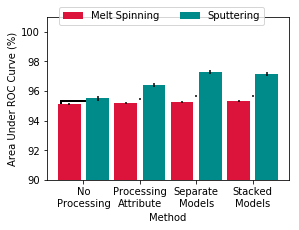

In [17]:
fig, ax = plt.subplots()


# Plot the data for all
data = pd.DataFrame(tests, columns=['method'])
acc = [results[t]['rocauc_total'][0]*100 for t in tests]
acc_err = [sum(np.abs(np.array(results[t]['rocauc_total'][1])*100 - mean))/2 for t,mean in zip(tests,acc)]
ax.bar(np.arange(0,len(acc)), acc, width=0.8,
               facecolor='none', edgecolor='black', linewidth=2,
               yerr=acc_err, error_kw=dict(ecolor='k', width=2))
data['total'], data['total_err'] = acc, acc_err

acc = [results[t]['rocauc_meltspin'][0]*100 for t in tests]
acc_err = [sum(np.abs(np.array(results[t]['rocauc_meltspin'][1])*100 - mean))/2 for t,mean in zip(tests,acc)]
rects_ms = ax.bar(np.arange(0,len(acc))-0.25, acc, width=0.4, color='crimson',
       yerr=acc_err, error_kw=dict(ecolor='k', width=2))
data['meltspin'], data['meltspin_err'] = acc, acc_err

acc = [results[t]['rocauc_sputtering'][0]*100 for t in tests]
acc_err = [sum(np.abs(np.array(results[t]['rocauc_sputtering'][1])*100 - mean))/2 for t,mean in zip(tests,acc)]
rects_sp = ax.bar(np.arange(0,len(acc))+ 0.25, acc, width=0.4, color='darkcyan',
       yerr=acc_err, error_kw=dict(ecolor='k', width=2))
data['sputtering'], data['sputtering_err'] = acc, acc_err

ax.legend((rects_ms[0],rects_sp[0]), ('Melt Spinning', 'Sputtering'), ncol=2, loc=(0.05,0.95))
        
# Label the axes
ax.set_ylabel('Area Under ROC Curve (%)')
ax.set_xlabel('Method')
ax.set_xticks(np.arange(0,len(acc)))
ax.set_xticklabels(test_names)

ax.set_ylim(90, 101);

fig.tight_layout()
fig.set_size_inches(plotWidth, plotHeight)

fig.savefig('cv_rocauc.png', dpi=320)
data